# Rules-Based System (RBS) example

This notebook contains an example of how Iguanas can be used to set up a Rules-Based System (RBS) from scratch. This includes:

* Generating new rules
* Optimising existing rules
* Combining these rules and removing those which are unnecessary
* Setting up and optimising the RBS pipeline
* Testing the optimised RBS pipeline on a test set

In this example, we'll be creating an RBS for a **transaction fraud use case** (i.e. identifying potentially fraudulent transactions). The metric that we'll optimising for will be the **F1 Score**, and we'll just be focusing on **rules to capture fraudulent behaviour** (rather than also including rules which capture good behaviour, which is a relevant methodology to use too).

## Requirements

To run, you'll need the following:

* A raw, labelled dataset.

---

## Table of contents

1. [Read/process data](#ReadProcessData)
2. [Rule Generation](#RuleGeneration)
3. [Rule Optimisation](#RuleOptimisation)
4. [Combine rules and remove those which are unnecessary](#CombineRules)
5. [Set up the RBS Pipeline](#SetUpPipeline)
6. [Optimise the RBS Pipeline](#OptimiseThePipeline)
7. [Filter rules for the optimised RBS Pipeline](#FilterRulesForPipeline)
8. [Apply the optimised RBS Pipeline to the test set](#ApplyPipeline)
9. [Our final rule set and RBS Pipeline](#FinalRuleSet)

----

## Import packages

In [104]:
from iguanas.rule_generation import RuleGeneratorDT
from iguanas.rule_optimisation import BayesianOptimiser
from iguanas.metrics.classification import FScore
from iguanas.metrics.pairwise import JaccardSimilarity
from iguanas.rules import Rules, ConvertProcessedConditionsToGeneral, ReturnMappings
from iguanas.correlation_reduction import AgglomerativeClusteringReducer
from iguanas.rule_selection import SimpleFilter, GreedyFilter, CorrelatedFilter, GridSearchCV
from iguanas.rbs import RBSPipeline, RBSOptimiser

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders.one_hot import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from hyperopt import tpe, anneal
import pickle

---

## Read/process data <a name="ReadProcessData"></a>

### Read in data

In [105]:
data = pd.read_csv(
    'dummy_data/dummy_pipeline_output_data.csv',
    index_col='eid'
)

In [106]:
data.shape

(13276, 64)

Then we can split the data into features (*X*) and the target column (*y*):

In [107]:
fraud_column = 'sim_is_fraud'
X = data.drop(
    fraud_column, 
    axis=1
)
y = data[fraud_column]

### Process the data

#### Train/test split

Before applying any data processing steps, we should split the data into training and test sets:

In [108]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.33, 
    random_state=0
)

#### Process data for rule generation

When generating new rules, we need to first process the data. The main data processesing steps that need to be applied before using the rule generator are:

* Remove uneccessary columns
* Impute null values
* One hot encode categorical features
* Feature selection ***(in this case, the feature set is small, so this step is omitted from the example)***

##### Remove unnecessary columns

We need to remove those columns which will not be useful or make sense to have in our rules - in this case, this includes any features whose name containis 'sim', 'eid' or any high cardinality columns. Note however that there may be additional columns that you have to remove from your dataset:

In [109]:
sim_cols = X_train.filter(regex='sim_').columns.tolist()
eid_cols = X_train.filter(regex='eid').columns.tolist()
high_card_cols = X_train.select_dtypes(include='object').columns[(X_train.select_dtypes(include='object').nunique() > 50)].tolist()

In [110]:
X_train = X_train.drop(sim_cols + eid_cols + high_card_cols, axis=1)
X_test = X_test.drop(sim_cols + eid_cols + high_card_cols, axis=1)

In [111]:
X_train.shape, X_test.shape

((8894, 27), (4382, 27))

##### Impute null values

We can now impute the null values. You can use any imputation method you like - here we'll impute using the following methodology:

* Impute numeric values with -1.
* Impute categorical features with the category 'missing'.
* Impute boolean features with 'missing'.

In [112]:
print("Number of null values in X_train:", X_train.isna().sum().sum())

Number of null values in X_train: 4766


In [113]:
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(include=object).columns.tolist()
bool_cols = X_train.select_dtypes(include=bool).columns.tolist()

In [114]:
X_train[bool_cols] = X_train[bool_cols].astype(object)
X_test[bool_cols] = X_test[bool_cols].astype(object)

In [115]:
X_train.loc[:, num_cols] = X_train.loc[:, num_cols].fillna(-1)
X_train.loc[:, cat_cols] = X_train.loc[:, cat_cols].fillna('missing')
X_train.loc[:, bool_cols] = X_train.loc[:, bool_cols].fillna('missing')
X_test.loc[:, num_cols] = X_test.loc[:, num_cols].fillna(-1)
X_test.loc[:, cat_cols] = X_test.loc[:, cat_cols].fillna('missing')
X_test.loc[:, bool_cols] = X_test.loc[:, bool_cols].fillna('missing')

In [116]:
print("Number of null values in X_train:", X_train.isna().sum().sum())

Number of null values in X_train: 0


##### One hot encode categorical features

Now we can one hot encode the categorical features:

In [117]:
ohe = OneHotEncoder(use_cat_names=True)

In [118]:
ohe.fit(X_train)
X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

/Users/jlaidler/venvs/iguanas_os_dev/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [119]:
X_train.shape, X_test.shape

((8894, 29), (4382, 29))

---

## Rule generation (using GridSearchCV) <a name="RuleGeneration"></a>

Now that we've processed our raw data, we can use this to generate rules. There are two rule generator algorithms in Iguanas:

* **RuleGeneratorDT**: Generate rules by extracting the highest performing branches from a tree ensemble model.
* **RuleGeneratorOpt**: Generate rules by optimising the thresholds of single features and combining these one condition rules with AND conditions to create more complex rules.

We can also use the *GridSearchCV* class to implement stratifield k-fold cross validation when searching for the best rule generation parameters. **This allows us to find the best rule generation parameters whilst also reducing the likelihood of overfitting.**

**In this example, we'll only use the RuleGeneratorDT, but you can use the RuleGeneratorOpt instead or additionally.**

### Set up class parameters

We first need to define the search values for each parameter in the provided rule generation class. We define these in a dictionary, where the dictionary keys are the relevant rule generation parameters and the dictionary values are lists of search values for each parameter. The *GridSearchCV* class will then calculate each unique combination of parameter values, and find the set of parameters that produce the best mean overall rule performance across the folds.

In [120]:
f1 = FScore(beta=1)

In [121]:
param_grid = {
    'opt_func': [f1.fit], 
    'n_total_conditions': [3, 4, 5], 
    'tree_ensemble': [
        RandomForestClassifier(n_estimators=15, random_state=0), 
        RandomForestClassifier(n_estimators=30, random_state=0), 
    ],
    'target_feat_corr_types': ['Infer']
}

Now that we have our search values, we can define the rest of the *GridSearchCV* class parameters. **Note here that we are splitting the data into 3 folds for training/validation.**

**Please see the class docstring for more information on each parameter**

In [122]:
params = {
    'rule_class': RuleGeneratorDT,
    'param_grid': param_grid,
    'greedy_filter_opt_func': f1.fit,
    'cv': 3,
    'num_cores': 4,
    'verbose': 1
}

### Instantiate class and run fit method

Once the parameters have been set, we can run the *.fit()* method to search for the best rule generation parameters.

In [123]:
gs_gen = GridSearchCV(**params)

6 unique parameter sets


In [124]:
gs_gen.fit(
    X=X_train, 
    y=y_train
)

--- Fitting and validating rules using folds ---
100%|██████████| 18/18 [00:00<00:00, 20.02it/s]
--- Re-fitting rules using best parameters on full dataset ---
--- Filtering rules to give best combined performance ---


### Outputs

The *.fit()* method does not return any objects. However, it does generate the following useful attributes:

* rule_strings (Dict[str, str]): The rules which achieved the best combined performance, defined using the standard Iguanas string format (values) and their names (keys).                    
* param_results_per_fold (pd.DataFrame): Shows the best combined rule performance observed for each parameter set and fold.
* param_results_aggregated (pd.DataFrame): Shows the mean and the standard deviation of the best combined rule performance, calculated across the folds, for each parameter set.
* best_perf (float): The best combined rule performance achieved.
* best_params (dict): The parameter set that achieved the best combined rule performance.

In [125]:
gs_gen.param_results_per_fold.head(2)

opt_func  \
Fold ParamSetIndex                                                    
0    0              <bound method FScore.fit of FScore with beta=1>   
     1              <bound method FScore.fit of FScore with beta=1>   

                   n_total_conditions  \
Fold ParamSetIndex                      
0    0                              3   
     1                              3   

                                                        tree_ensemble  \
Fold ParamSetIndex                                                      
0    0              (DecisionTreeClassifier(max_depth=3, max_featu...   
     1              RandomForestClassifier(n_estimators=30, random...   

                   target_feat_corr_types  Performance  
Fold ParamSetIndex                                      
0    0                              Infer     0.993939  
     1                              Infer     0.993939

In [126]:
gs_gen.param_results_aggregated.head(2)

,opt_func,n_total_conditions,tree_ensemble,target_feat_corr_types,PerformancePerFold,MeanPerformance,StdDevPerformance
ParamSetIndex,,,,,,,
0,<bound method FScore.fit of FScore with beta=1>,3,"(DecisionTreeClassifier(max_depth=3, max_featu...",Infer,"[0.993939393939394, 1.0, 0.9938650306748467]",0.995935,0.002875
1,<bound method FScore.fit of FScore with beta=1>,3,"RandomForestClassifier(n_estimators=30, random...",Infer,"[0.993939393939394, 1.0, 0.9938650306748467]",0.995935,0.002875


In [127]:
gs_gen.best_perf

0.9959348082047469

In [128]:
gs_gen.best_params

{'opt_func': <bound method FScore.fit of FScore with beta=1>,
 'n_total_conditions': 3,
 'tree_ensemble': RandomForestClassifier(max_depth=3, n_estimators=15, random_state=0),
 'target_feat_corr_types': 'Infer'}

----

## Rule Optimisation (using GridSearchCV) <a name="RuleOptimisation"></a>

Now we can optimise the existing rules.

First, we'll read in the existing rules, which have been stored in the standard Iguanas string format:

In [129]:
with open('dummy_data/rule_strings.pkl', 'rb') as f:
    rule_strings = pickle.load(f)

We can then instantiate the *Rules* class with these rules, so that we can convert them into the standard Iguanas lambda expression format:

In [130]:
existing_rules = Rules(rule_strings=rule_strings)

To convert the rules, we use the *as_rule_lambdas()* method from the instantiated *Rules* class:

In [131]:
existing_rule_lambdas = existing_rules.as_rule_lambdas(as_numpy=False, with_kwargs=True)

The standard Iguanas lambda expression format allows new values to be injected into the condition string of a rule. This means that the rule's performance can be evaluated with new values (this capability is leveraged in the rule optimisers).

We can now use the *GridSearchCV* class to implement stratifield k-fold cross validation to search for the best rule optimisation parameters. **This allows us to find the best rule optimisation parameters whilst also reducing the likelihood of overfitting.**

### Set up class parameters

We firstly need to define the search values for each parameter in the provided rule optimisation class. We define these in a dictionary, where the dictionary keys are the relevant rule optimisation parameters and the dictionary values are lists of search values for each parameter. The *GridSearchCV* class will then calculate each unique combination of parameter values, and find the set of parameters that produce the best mean overall rule performance across the folds.

In [132]:
f0dot5 = FScore(beta=0.5)
f1 = FScore(beta=1)

In [133]:
param_grid = {
    'rule_lambdas': [existing_rule_lambdas],
    'lambda_kwargs': [existing_rules.lambda_kwargs],
    'opt_func': [f0dot5.fit, f1.fit],
    'n_iter': [30],
    'algorithm': [tpe.suggest, anneal.suggest],
    'verbose': [0]
}

Now that we have our search values, we can define the rest of the *GridSearchCV* class parameters. **Note here that we are splitting the data into 3 folds for training/validation.**

**Please see the class docstring for more information on each parameter**

In [134]:
params = {
    'rule_class': BayesianOptimiser,
    'param_grid': param_grid,
    'greedy_filter_opt_func': f1.fit,
    'cv': 3,
    'num_cores': 4,
    'verbose': 1
}

### Instantiate class and run fit method

Once the parameters have been set, we can run the *.fit()* method to search for the best rule optimisation parameters. **Note that we use the raw, unprocessed data here, as productionised rules will usually run on raw data:**

In [135]:
gs_opt = GridSearchCV(**params)

4 unique parameter sets


In [136]:
gs_opt.fit(
    X=X.loc[X_train.index], 
    y=y_train
)

--- Fitting and validating rules using folds ---
  0%|          | 0/12 [00:00<?, ?it/s]

/Users/jlaidler/Documents/argo/iguanas/rule_optimisation/_base_optimiser.py:189: UserWarning: Rules `Rule2`, `Rule3` have no optimisable conditions - unable to optimise these rules
  warnings.warn(
/Users/jlaidler/Documents/argo/iguanas/rule_optimisation/_base_optimiser.py:189: UserWarning: Rules `Rule2`, `Rule3` have no optimisable conditions - unable to optimise these rules
  warnings.warn(
/Users/jlaidler/Documents/argo/iguanas/rule_optimisation/_base_optimiser.py:189: UserWarning: Rules `Rule2`, `Rule3` have no optimisable conditions - unable to optimise these rules
  warnings.warn(
/Users/jlaidler/Documents/argo/iguanas/rule_optimisation/_base_optimiser.py:189: UserWarning: Rules `Rule2`, `Rule3` have no optimisable conditions - unable to optimise these rules
  warnings.warn(


 67%|██████▋   | 8/12 [00:02<00:01,  3.87it/s]

/Users/jlaidler/Documents/argo/iguanas/rule_optimisation/_base_optimiser.py:189: UserWarning: Rules `Rule2`, `Rule3` have no optimisable conditions - unable to optimise these rules
  warnings.warn(
/Users/jlaidler/Documents/argo/iguanas/rule_optimisation/_base_optimiser.py:189: UserWarning: Rules `Rule2`, `Rule3` have no optimisable conditions - unable to optimise these rules
  warnings.warn(
/Users/jlaidler/Documents/argo/iguanas/rule_optimisation/_base_optimiser.py:189: UserWarning: Rules `Rule2`, `Rule3` have no optimisable conditions - unable to optimise these rules
  warnings.warn(
/Users/jlaidler/Documents/argo/iguanas/rule_optimisation/_base_optimiser.py:189: UserWarning: Rules `Rule2`, `Rule3` have no optimisable conditions - unable to optimise these rules
  warnings.warn(


100%|██████████| 12/12 [00:03<00:00,  3.04it/s]


/Users/jlaidler/Documents/argo/iguanas/rule_optimisation/_base_optimiser.py:189: UserWarning: Rules `Rule2`, `Rule3` have no optimisable conditions - unable to optimise these rules
  warnings.warn(
/Users/jlaidler/Documents/argo/iguanas/rule_optimisation/_base_optimiser.py:189: UserWarning: Rules `Rule2`, `Rule3` have no optimisable conditions - unable to optimise these rules
  warnings.warn(
/Users/jlaidler/Documents/argo/iguanas/rule_optimisation/_base_optimiser.py:189: UserWarning: Rules `Rule2`, `Rule3` have no optimisable conditions - unable to optimise these rules
  warnings.warn(
/Users/jlaidler/Documents/argo/iguanas/rule_optimisation/_base_optimiser.py:189: UserWarning: Rules `Rule2`, `Rule3` have no optimisable conditions - unable to optimise these rules
  warnings.warn(


--- Re-fitting rules using best parameters on full dataset ---


/Users/jlaidler/Documents/argo/iguanas/rule_optimisation/_base_optimiser.py:189: UserWarning: Rules `Rule2`, `Rule3` have no optimisable conditions - unable to optimise these rules
  warnings.warn(


--- Filtering rules to give best combined performance ---


### Outputs

The *.fit()* method does not return any objects. However, it does generate the following useful attributes:

* rule_strings (Dict[str, str]): The rules which achieved the best combined performance, defined using the standard Iguanas string format (values) and their names (keys).                    
* param_results_per_fold (pd.DataFrame): Shows the best combined rule performance observed for each parameter set and fold.
* param_results_aggregated (pd.DataFrame): Shows the mean and the standard deviation of the best combined rule performance, calculated across the folds, for each parameter set.
* best_perf (float): The best combined rule performance achieved.
* best_params (dict): The parameter set that achieved the best combined rule performance.

**Note the following cases where the rule optimiser will be unable to run:**

* Rules that contain features that are missing in `X`.
* Rules that contain no optimisable features (e.g. all of the conditions are string-based).
* Rules that contain exclusively zero variance features.
* Rules that contain a feature that is completely null in `X`.

In [137]:
gs_opt.param_results_per_fold.head(2)

rule_lambdas  \
Fold ParamSetIndex                                                      
0    0              {'RGDT_Rule137': <function ConvertRuleDictsToR...   
     1              {'RGDT_Rule137': <function ConvertRuleDictsToR...   

                                                        lambda_kwargs  \
Fold ParamSetIndex                                                      
0    0              {'RGDT_Rule137': {'account_number_avg_order_to...   
     1              {'RGDT_Rule137': {'account_number_avg_order_to...   

                                                             opt_func n_iter  \
Fold ParamSetIndex                                                             
0    0              <bound method FScore.fit of FScore with beta=0.5>     30   
     1              <bound method FScore.fit of FScore with beta=0.5>     30   

                                               algorithm verbose  Performance  
Fold ParamSetIndex                                                             
0    0              <function suggest at 0x7fc179a0bd30>       0     0.993939  
     1              <function suggest at 0x7fc1b0a8c550>       0     0.993939

In [138]:
gs_opt.param_results_aggregated.head(2)

,rule_lambdas,lambda_kwargs,opt_func,n_iter,algorithm,verbose,PerformancePerFold,MeanPerformance,StdDevPerformance
ParamSetIndex,,,,,,,,,
0,{'RGDT_Rule137': <function ConvertRuleDictsToR...,{'RGDT_Rule137': {'account_number_avg_order_to...,<bound method FScore.fit of FScore with beta=0.5>,30,<function suggest at 0x7fc179a0bd30>,0,"[0.993939393939394, 1.0, 0.9938650306748467]",0.995935,0.002875
1,{'RGDT_Rule137': <function ConvertRuleDictsToR...,{'RGDT_Rule137': {'account_number_avg_order_to...,<bound method FScore.fit of FScore with beta=0.5>,30,<function suggest at 0x7fc1b0a8c550>,0,"[0.993939393939394, 1.0, 0.9938650306748467]",0.995935,0.002875


In [139]:
gs_opt.best_perf

0.9959348082047469

---

## Combine rules and remove those which are unnecessary <a name="CombineRules"></a>

We now have two sets of rules:

1. Newly generated rules
2. Optimised existing rules

We can combine these rule sets, then apply correlation reduction and filtering methods to remove those which are unneccesary.

To do this, we need to calculate the binary columns and the performance dataframes of each rule set. This can be done using the *apply* method from each of the instantiated *GridSearchCV* classes (one for our generated rules; one for our optimised rules):

In [140]:
# Generated rules
X_rules_gen_train = gs_gen.transform(
    X=X_train, 
    y=y_train
)
# Optimised rules (note we use the raw, unprocessed data here)
X_rules_opt_train = gs_opt.transform(
    X=X.loc[X_train.index], 
    y=y_train
)

Now we can combine the binary columns and performance dataframes of each rule set:

In [141]:
X_rules_train = pd.concat([
    X_rules_gen_train, 
    X_rules_opt_train
], axis=1)

rule_descriptions_train = pd.concat([
    gs_gen.rule_descriptions, 
    gs_opt.rule_descriptions
], axis=0)

In [142]:
X_rules_train.head(2)

Rule,RGDT_Rule_20211202_27,RGDT_Rule_20211202_24,RGDT_Rule_20211202_22,RGDT_Rule_20211202_25,RGDT_Rule_20211202_16,RGDT_Rule_20211202_17,RGDT_Rule_20211202_31,HighFraudTxnPerAccountNum,RGDT_Rule256,RGDT_Rule193,RGDT_Rule45,RGDT_Rule241,RGDT_Rule313
eid,,,,,,,,,,,,,
503-0182982-0226911,1,0,0,1,0,0,0,1,1,0,0,0,1
516-2441570-6696110,0,0,0,0,0,0,0,0,0,0,0,0,0


In [143]:
rule_descriptions_train.head(2)

,Precision,Recall,PercDataFlagged,OptMetric,Logic,nConditions
Rule,,,,,,
RGDT_Rule_20211202_27,0.991903,1.000000,0.027772,0.995935,(X['account_number_num_fraud_transactions_per_...,2
RGDT_Rule_20211202_24,1.000000,0.730612,0.020126,0.844340,(X['account_number_num_fraud_transactions_per_...,2


In [144]:
X_rules_train.shape, rule_descriptions_train.shape

((8894, 13), (13, 6))

### Standard filter

We can use the *SimpleFilter* class from the *rule_selection* module to filter out rules whose performance is below a desired threshold. In this example, we'll filter out rules with an F1 score below 0.01. Let's first set up our filters - **note that we use the key 'OptMetric' for the F1 score (since this is the metric that we used to generate and optimise the rules):**

In [145]:
filters = {
    'OptMetric': {
        'Operator': '>=',
        'Value': 0.01
    }
}

Now we can instantiate the *SimpleFilter* class and run the *fit_transform()* method to remove the rules which do not meet the filter requirements:

In [146]:
fr = SimpleFilter(
    filters=filters, 
    rule_descriptions=rule_descriptions_train
)

In [147]:
X_rules_train = fr.fit_transform(
    X_rules=X_rules_train, 
    y=y_train
)

#### Outputs

The *.fit_transform()* method returns a dataframe containing the filtered rule binary columns. It also creates the following useful attributes:

- rules_to_keep (list): List of rules which remain after the filters have been applied.
- rule_descriptions (pd.DataFrame): The standard performance metrics dataframe associated with the filtered rules.

We can assign the *rule_descriptions* dataframe from the class to our variable, ensuring that the filtered rules are removed from the dataframe:

In [148]:
rule_descriptions_train = fr.rule_descriptions

In [149]:
X_rules_train.shape, rule_descriptions_train.shape

((8894, 11), (11, 6))

### Remove correlated rules

We can use the *CorrelatedFilter* class from the *rule_selection* module along with a correlation reduction class to remove correlated rules - see the *correlation_reduction_methods* module for more information on these classes. 

In this example, we'll be using the *AgglomerativeClusteringReducer* class from that module. To instantiate this class, we also need to define a similarity function - see the *similarity_functions* module for more information. In this example, we'll use the Jaccard similarity:

In [150]:
js = JaccardSimilarity()

In [151]:
acfr = AgglomerativeClusteringReducer(
    threshold=0.75,
    strategy='bottom_up', 
    similarity_function=js.fit, 
    columns_performance=rule_descriptions_train['OptMetric']
)

Now we can instantiate the *CorrelatedFilter* class, and run the *fit_transform()* method to remove correlated rules:

In [152]:
fcr = CorrelatedFilter(
    correlation_reduction_class=acfr, 
    rule_descriptions=rule_descriptions_train
)

In [153]:
X_rules_train = fcr.fit_transform(X_rules=X_rules_train)

#### Outputs

The *.fit_transform()* method returns a dataframe containing the binary columns of the uncorrelated rules. It also creates the following useful attributes:

- rules_to_keep (list): List of rules which remain after the correlation reduction has been applied.
- rule_descriptions (pd.DataFrame): The standard performance metrics dataframe associated with the uncorrelated rules.

We can assign the *rule_descriptions* dataframe from the class to our variable, ensuring that the correlated rules are removed from the dataframe:

In [154]:
rule_descriptions_train = fcr.rule_descriptions

In [155]:
X_rules_train.shape, rule_descriptions_train.shape

((8894, 9), (9, 6))

### Greedy filter

We can use the *GreedyFilter* class from the *rule_selection* module to sort the rules by a given metric (e.g. precision), then iterate through the rules and calculate the combined performance of the top n number of rules. Here, we'll sort the rules by precision, then calculate the F1 score of the top n combined rules:

In [156]:
gf = GreedyFilter(
    opt_func=f1.fit, 
    rule_descriptions=rule_descriptions_train, 
    sorting_col='Precision', 
    verbose=1
)

In [157]:
X_rules_train = gf.fit_transform(
    X_rules=X_rules_train, 
    y=y_train
)

--- Calculating performance of top n rules ---
100%|██████████| 9/9 [00:00<00:00, 738.43it/s]


We can also plot the combined performance of the top *n* rules (calculated from running the *.fit()* method) on the training set using the *.plot_top_n_performance_on_train()* method:

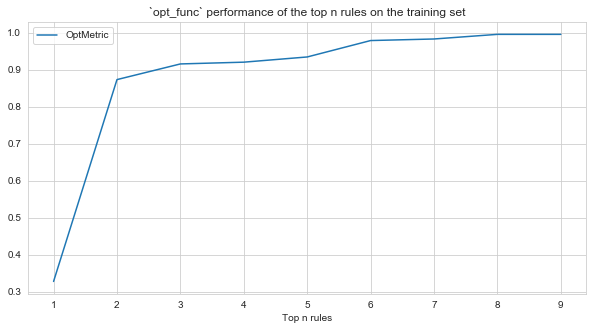

In [158]:
gf.plot_top_n_performance_on_train()

The graph shows that when the rules are sorted by precision, then the F1 score is calculated for the top n combined rules, the combined performance begins to plateau/drop. So the algorithm will only keep those rules that deliver the maximum combined performance (and drop the rest).

#### Outputs

The *.fit_transform()* method returns a dataframe containing the filtered rule binary columns. It also creates the following useful attributes:

- rules_to_keep (list): List of rules which remain after the filters have been applied.
- rule_descriptions (pd.DataFrame): The standard performance metrics dataframe associated with the filtered rules.

We can assign the *rule_descriptions* dataframe from the class to our variable, ensuring that the filtered rules are removed from the dataframe:

In [159]:
rule_descriptions_train = gf.rule_descriptions

In [160]:
X_rules_train.shape, rule_descriptions_train.shape

((8894, 8), (8, 6))

----

## Set up the RBS Pipeline <a name="SetUpPipeline"></a>

Now, let's set up our RBS Pipeline using our combined, filtered rule set. In this case, we'll go for a simple approach:

1. If any rules trigger, reject the transaction.
2. If no rules trigger, approve any remaining transactions.

To set up the pipeline using the logic above, we first need to create the *config* - this is just a list which outlines the stages of the pipeline. Each stage should be defined using a single-element dictionary, where the key corresponds to the decision at that stage (either *0* or *1*), and the value is a list that dictates which rules should trigger for that decision to be made.

In our example, the config will be:

In [161]:
config = [
    {1: X_rules_train.columns.tolist()}
]

Here, the first stage is configured via the dictionary in the first element of the list. This says to apply a decision of *1* (i.e. reject) to transactions where the any of the rules have triggered.

We also need to specify the final decision to be made if no rules are triggered - this is set via the *final_decision* parameter. In our case this should be *0*, as we want to approve any remaining transactions:

In [162]:
final_decision = 0

With these parameters configured, we can now instantiate our *RBSPipeline* class:

In [163]:
rbsp = RBSPipeline(
    config=config,
    final_decision=final_decision,
    opt_func=f1.fit
)

---

## Optimise the RBS Pipeline <a name="OptimiseThePipeline"></a>

Now that we have our RBS Pipeline set up, we can optimise it using the RBS Optimiser. Here, we just pass the instatiated pipeline class to the *pipeline* parameter:

In [164]:
rbso = RBSOptimiser(
    pipeline=rbsp, 
    n_iter=60, 
    verbose=1
)

Then we run the *.fit_transform()* method to optimise the pipeline using the given dataset, then apply it to the dataset:

In [165]:
pipe_pred_train = rbso.fit_predict(
    X_rules=X_rules_train, 
    y=y_train
)

100%|██████████| 60/60 [00:00<00:00, 83.16trial/s, best loss: -0.9959349593495934]


### Outputs

The *.fit_transform()* method optimises the pipeline and returns the prediction of the optimised pipeline by applying it to the given dataset.

Useful attributes created by running the *.fit_transform()* method are:

* config (List[str]): The optimised pipeline configuration, where each element aligns to a stage in the pipeline. Each element is a dictionary, where the key is the decision made at that stage (either 0 or 1) and the value is a list of the rules that must trigger to give that decision.
* pipeline_opt_metric (float): The result of the `opt_func` function when the pipeline is applied.

In [166]:
rbso.config

[{1: ['RGDT_Rule_20211202_25',
   'RGDT_Rule_20211202_24',
   'RGDT_Rule193',
   'RGDT_Rule241',
   'RGDT_Rule_20211202_27']}]

In [167]:
rbso.pipeline_opt_metric

0.9959349593495934

We can also use the *.calc_performance()* method to generate some performance metrics for the pipeline:

In [168]:
rbso.calc_performance(
    y_true=y_train, 
    y_pred=pipe_pred_train
)

In [169]:
rbso.pipeline_perf

,Precision,Recall,PercDataFlagged
1,0.991903,1.000000,0.027772
0,1.000000,0.999769,0.972228


In [170]:
rbso.conf_matrix

,1,0
1,245.0,2.0
0,0.0,8647.0


----

## Filter rules for the optimised RBS Pipeline <a name="FilterRulesForPipeline"></a>

Now that we know which rules we need for our final, optimised RBS Pipeline, we can filter our original generated and optimised rule sets to include only those rules which are required.

First, we get the rule names from the optimised RBS Pipeline config:

In [171]:
rbs_rule_names = [rule for stage_dict in rbso.config for rule in list(stage_dict.values())[0]]

Then we split them into rules that were generated and rules that were optimised:

In [172]:
rbs_rule_names_gen = [rule for rule in rbs_rule_names if rule in gs_gen.rule_strings.keys()]
rbs_rule_names_opt = [rule for rule in rbs_rule_names if rule in gs_opt.rule_strings.keys()]

Finally, we filter the original generated and optimised rule sets:

In [173]:
gs_gen.filter_rules(include=rbs_rule_names_gen)
gs_opt.filter_rules(include=rbs_rule_names_opt)

----

## Apply the optimised RBS Pipeline to the test set <a name="ApplyPipeline"></a>

To apply our optimised RBS Pipeline to the test set, we first need to apply our filtered generated and optimised rules to the test set:

In [174]:
# Generated rules
X_rules_gen_test = gs_gen.transform(
    X=X_test, 
    y=y_test
)
# Optimised rules (note we using the raw, unprocessed data here)
X_rules_opt_test = gs_opt.transform(
    X=X.loc[X_test.index], 
    y=y.loc[X_test.index]
)

Now we can combine these binary columns into one set:

In [175]:
X_rules_test = pd.concat([
    X_rules_gen_test, 
    X_rules_opt_test
], axis=1)

Then, using these binary columns, apply our optimised RBS Pipeline to the test set, using the *transform* method:

In [176]:
pipe_pred_test = rbso.predict(
    X_rules=X_rules_test, 
    y=y_test
)

### Outputs

The *.predict()* method returns the prediction of the optimised pipeline by applying it to the given dataset.

A useful attribute created by running the *.predict()* method is:

* pipeline_opt_metric (float): The result of the `opt_func` function when the pipeline is applied.

In [177]:
rbso.pipeline_opt_metric

0.9868995633187774

We can also use the *.calc_performance()* method to generate some performance metrics for the pipeline:

In [178]:
rbso.calc_performance(
    y_true=y_test, 
    y_pred=pipe_pred_test
)

In [179]:
rbso.pipeline_perf

,Precision,Recall,PercDataFlagged
1,0.982609,0.991228,0.026244
0,0.999766,0.999531,0.973756


In [180]:
rbso.conf_matrix

,1,0
1,113.0,2.0
0,1.0,4266.0


In [181]:
rbso.config

[{1: ['RGDT_Rule_20211202_25',
   'RGDT_Rule_20211202_24',
   'RGDT_Rule193',
   'RGDT_Rule241',
   'RGDT_Rule_20211202_27']}]

### Compare to initial RBS pipeline performance

If we assume that, for our initial RBS pipeline:

* Only the **original, existing rules** were used (since these are likely to be the rules that are currently productionised).
* The RBS pipeline was set up in a similar way to our optimised RBS Pipeline (i.e. if any rules trigger, reject the transaction; else, approve the transaction).

then we can calculate the performance of the initial RBS Pipeline and compare it to our optimised pipeline.

To set up the initial RBS Pipeline, we follow a similar process as before. First, we need the names of the **original, existing rules** that are used to reject transactions:

In [182]:
existing_rule_names = list(existing_rules.rule_strings.keys())

Then we can create our *config* using these rule names:

In [183]:
config = [
    {1: existing_rule_names}
]

Now, we need to apply the original, existing rules to the test set:

In [184]:
X_rules_existing_test = existing_rules.transform(
    X=X.loc[X_test.index],
    y=y.loc[X_test.index]
)

Then instantiate the *RBSPipeline* class using *config* we created above, keeping the other parameters the same:

In [185]:
rbsp_initial = RBSPipeline(
    config=config,
    final_decision=0,
    opt_func=f1.fit
)

Now we can apply the initial RBS pipeline to the test set:

In [186]:
pipe_pred_initial_test = rbsp_initial.predict(
    X_rules=X_rules_existing_test,
    y=y.loc[X_test.index]
)

We can also use the *.calc_performance()* method to generate some performance metrics for the pipeline:

In [187]:
rbsp_initial.calc_performance(
    y_true=y_test, 
    y_pred=pipe_pred_initial_test
)

#### Performance comparison

Finally, we can compare the performance of the initial RBS Pipeline and the optimised RBS Pipeline:

In [188]:
# F1 Score
print(f'The F1 score of the initial RBS Pipeline is: {round(rbsp_initial.pipeline_opt_metric, 3)}')
print(f'The F1 score of the optimised RBS Pipeline is: {round(rbso.pipeline_opt_metric, 3)}')
print(f'% improvement in F1 score is: {round(100*(rbso.pipeline_opt_metric-rbsp_initial.pipeline_opt_metric)/rbsp_initial.pipeline_opt_metric)}%')

The F1 score of the initial RBS Pipeline is: 0.092
The F1 score of the optimised RBS Pipeline is: 0.987
% improvement in F1 score is: 969%


In [189]:
conf_matrix_diff = rbso.conf_matrix - rbsp_initial.conf_matrix

In [190]:
print(f'Absolute change in true positives: {conf_matrix_diff.iloc[0, 0]}')
print(f'Absolute change in false positives: {conf_matrix_diff.iloc[0, 1]}')
print(f'Absolute change in true negatives: {conf_matrix_diff.iloc[1, 1]}')
print(f'Absolute change in false negatives: {conf_matrix_diff.iloc[1, 0]}')

Absolute change in true positives: -1.0
Absolute change in false positives: -2239.0
Absolute change in true negatives: 2239.0
Absolute change in false negatives: 1.0


---

## Convert generated rule conditions to system-ready <a name="ConvertGenToSys"></a>

Now that we have our final rule set and our optimised RBS Pipeline, we can convert the conditions of the generated rules to work on raw, unprocessed data (which is usually the type of data seen in a production system) - this involves the following:

* Adding a null condition if the generated condition covered imputed null values.
* Converting generated conditions with One Hot Encoded features into conditions that flag that specific category.

For example:

- If a numeric rule condition initially had a threshold such that the imputed null values were included in the condition, the converted condition has an additional condition to check whether the feature is also null. 
    - E.g. If a rule initially had the logic *(X['num_items']<=1)* (which included the imputed value of 0), then the converted rule logic would be *((X['num_items']<=1)|(X['num_items'].isna()))*, with an additional condition to check for nulls.
- If a categorical rule condition checks whether the value is the imputed null category, the converted condition is such that it will explicitly check for null values. 
    - E.g. If a rule initially had the logic *(X['country_missing']==True)*, then the converted rule logic would be *(X['country'].isna())*, such that it explicitly checks for null values.
- For categorical rule conditions, the converted condition is such that it will explicitly check for the category. 
    - E.g. If a rule initially had the logic *(X['country_US']==False)*, then the converted rule logic woul dbe *(X['country']!='US')*, such that it explicitly checks whether the 'country' column is not equal to the 'US' category.

To do this, we can use the *ConvertProcessedConditionsToGeneral* class from the *convert_processed_conditions_to_general* module. Note that we only need to apply this process to the generated rules, since those are the only rules which reference the processed data.

Before we can use this class, we need to provide the following:

* A dictionary of the value used to impute nulls for each feature in the original, unprocessed dataset.
* A dictionary of the category linked to each One Hot Encoded column.

To get these dictionaries, we can use the *ReturnMappings* class from the *convert_processed_conditions_to_general* module:

In [191]:
rm = ReturnMappings()

In [192]:
imputed_values_mapping = rm.return_imputed_values_mapping(
    [num_cols, -1], 
    [cat_cols, 'missing'], 
    [bool_cols, 'missing']
)

In [193]:
ohe_categories_mapping = rm.return_ohe_categories_mapping(
    pre_ohe_cols=X.columns, 
    post_ohe_cols=X_train.columns, 
    pre_ohe_dtypes=X.dtypes
)

Now that we have our mapping dictionaries for imputed values and one hot encoded values, we can convert the logic of our generated rules to make them production-ready:

In [194]:
conv_gen_rules = ConvertProcessedConditionsToGeneral(
    imputed_values=imputed_values_mapping, 
    ohe_categories=ohe_categories_mapping
)

In [195]:
conv_gen_rule_strings = conv_gen_rules.convert(
    rule_strings=gs_gen.rule_strings, 
    X=X_train
)

### Outputs

The *.convert()* method returns a dictionary containing the set of rules which account for imputed/OHE variables, defined using the standard Iguanas string format (values) and their names (keys). 

A useful attribute created by running the *.convert()* method is:

* rules: Class containing the rules stored in the standard Iguanas string format. Methods from this class can be used to convert the rules into the standard Iguanas dictionary or lambda expression representations. See the *rules* module for more information.

---

## Our final rule set and RBS Pipeline <a name="FinalRuleSet"></a>

We can now (finally!) create the rule set that we'll use in our optimised RBS pipeline. All we need to do is add our generated rules (that were reformatted for raw data) to our optimised rules:

In [196]:
rbs_rule_strings = {}
rbs_rule_strings.update(conv_gen_rule_strings)
rbs_rule_strings.update(gs_opt.rule_strings)

Then we can create an instance of the *Rules* class using these rules (we can use this class to change between representations of the rules, if required):

In [197]:
rbs_rules = Rules(rule_strings=rbs_rule_strings)

**Our final rules (in the standard Iguanas string format):**

In [198]:
rbs_rules.rule_strings

{'RGDT_Rule_20211202_27': "(X['account_number_num_fraud_transactions_per_account_number_7day']>=1)&(X['account_number_num_fraud_transactions_per_account_number_90day']>=1)",
 'RGDT_Rule_20211202_24': "(X['account_number_num_fraud_transactions_per_account_number_30day']>=1)&((X['is_existing_user']<=0)|(X['is_existing_user'].isna()))",
 'RGDT_Rule_20211202_25': "(X['account_number_num_fraud_transactions_per_account_number_30day']>=1)&(X['order_total']>916.82501)",
 'RGDT_Rule193': "(X['account_number_num_distinct_transaction_per_account_number_30day']>=2.0)&(X['account_number_num_fraud_transactions_per_account_number_lifetime']>=2.0)",
 'RGDT_Rule241': "(X['account_number_avg_order_total_per_account_number_90day']>153.949)&(X['account_number_num_fraud_transactions_per_account_number_1day']>=1.0)&((X['account_number_sum_order_total_per_account_number_1day']<=623.10999)|(X['account_number_sum_order_total_per_account_number_1day'].isna()))&(X['account_number_sum_order_total_per_account_numb

**Our optimised RBS Pipeline configuration:**

In [199]:
rbso.config

[{1: ['RGDT_Rule_20211202_25',
   'RGDT_Rule_20211202_24',
   'RGDT_Rule193',
   'RGDT_Rule241',
   'RGDT_Rule_20211202_27']}]

---